# Getting the necessary data

You just need to do this only once

In [1]:
#!sudo apt-get install tabix
!rm -f genotypes.vcf.gz 2>/dev/null
!tabix -fh ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/supporting/vcf_with_sample_level_annotation/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5_extra_anno.20130502.genotypes.vcf.gz 22:1-17000000|bgzip -c > genotypes.vcf.gz
!tabix -p vcf genotypes.vcf.gz #create index

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

#### 1.Let's start by inspecting the information that we can get per record:

In [3]:
#!source activate bioinformatics
#!pip install pyvcf

import vcf
v = vcf.Reader(filename='genotypes.vcf.gz')

print('Variant Level information')
infos = v.infos
for info in infos:
    print(info)

print('Sample Level information')
fmts = v.formats
for fmt in fmts:
    print(fmt)

Variant Level information
CIEND
CIPOS
CS
END
IMPRECISE
MC
MEINFO
MEND
MLEN
MSTART
SVLEN
SVTYPE
TSD
AC
AF
NS
AN
ASN_AF
EUR_AF
AFR_AF
AMR_AF
SAN_AF
DP
Sample Level information
GT
DP


#### 2.Now that we know which information is available, let's inspect a single VCF record:

In [4]:
v = vcf.Reader(filename='genotypes.vcf.gz')
rec = next(v)
print(rec.CHROM, rec.POS, rec.ID, rec.REF, rec.ALT, rec.QUAL, rec.FILTER)
print(rec.INFO)
print(rec.FORMAT)
samples = rec.samples
print(len(samples))
sample = samples[0]
print(sample.called, sample.gt_alleles, sample.is_het, sample.is_variant, sample.phased)
print(int(sample['DP']))

('22', 16050075, None, 'A', [G], 100, [])
{'EUR_AF': [0.0], 'SAS_AF': ['0.0010'], 'AC': [1], 'AF': [0.000199681], 'ASN_AF': [0.0], 'AFR_AF': [0.0], 'AMR_AF': [0.0], 'AN': 5008, 'SAN_AF': [0.0], 'EAS_AF': [''], 'NS': 2504, 'DP': [8012]}
GT:DP
2504
(True, ['0', '0'], False, False, True)
1


#### 3.Let's check the type of variant and the number of non-biallelic SNPs in a single pass:

In [5]:
from collections import defaultdict
f = vcf.Reader(filename='genotypes.vcf.gz')

my_type = defaultdict(int)
num_alts = defaultdict(int)

for rec in f:
    my_type[rec.var_type, rec.var_subtype] += 1
    if rec.is_snp:
        num_alts[len(rec.ALT)] += 1
print(my_type)
print(num_alts)

defaultdict(<type 'int'>, {('indel', 'del'): 273, ('indel', 'ins'): 127, ('snp', 'ts'): 10054, ('sv', 'SVA'): 1, ('indel', 'unknown'): 13, ('snp', 'unknown'): 79, ('snp', 'tv'): 5917, ('sv', 'DEL'): 6, ('sv', 'CNV'): 2})
defaultdict(<type 'int'>, {1: 15971, 2: 79})


In [6]:
f = vcf.Reader(filename='genotypes.vcf.gz')

sample_dp = defaultdict(int)
for rec in f:
    if not rec.is_snp or len(rec.ALT) != 1:
        continue
    for sample in rec.samples:
        dp = sample['DP']
        if dp is None:
            dp = 0
        dp = int(dp)
        sample_dp[dp] += 1

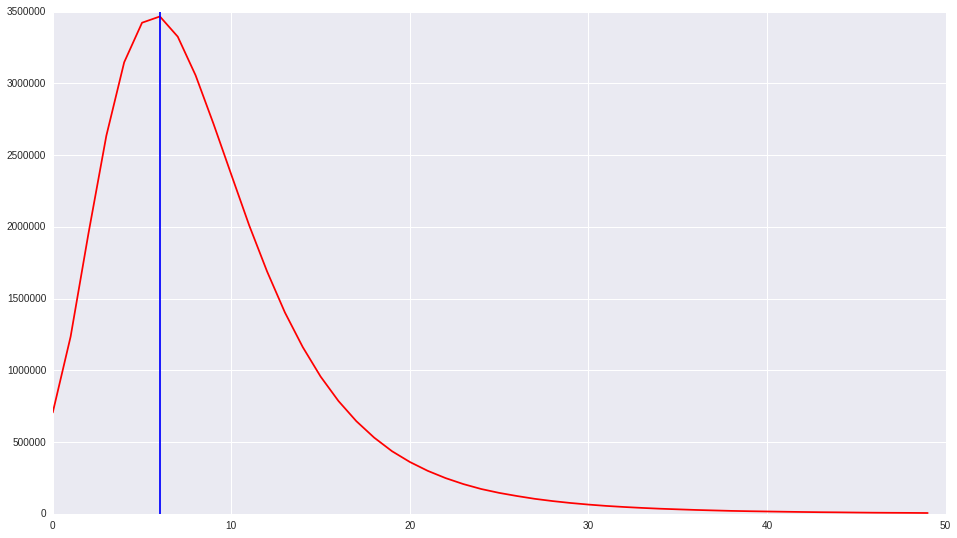

In [7]:
dps = sample_dp.keys()
dps.sort()
dp_dist = [sample_dp[x] for x in dps]
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(dp_dist[:50], 'r')
ax.axvline(dp_dist.index(max(dp_dist)))

### There's more…
The purpose of this recipe is to get you up to speed on the PyVCF module. At this stage, you
should be comfortable with the API. We will not spend too much time here on usage details
because this will be the main purpose of the next recipe: using the VCF module to study the
quality of your variant calls.

### See also
- The specification for VCF : http://samtools.github.io/hts-specs/VCFv4.2.pdf
- GATK : one of the most widely used variant callers; https://www.broadinstitute.org/gatk/
- samtools, htslib : used for variant calling and SAM/BAM management; http://htslib.org